<a href="https://colab.research.google.com/github/ap0phasi/cerberusPy/blob/feature%2Fmamba_layer/example_cerberus_colab_mamba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

Google Colab notebooks come with most of the packages we need, but we need to upgrade pandas and install accelerate.

In [1]:
!pip install causal-conv1d>=1.2.0
!pip install mamba-ssm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.9 MB/s eta 0:00:00
  Created wheel for mamba-ssm: filename=mamba_ssm-1.2.0.post1-cp310-cp310-linux_x86_64.whl size=137750683 sha256=b264292652a34fb9dd0ce880a34a4407ba7256a3338388d056769ec29a4581c9
  Stored in directory: /root/.cache/pip/wheels/22/6e/60/ddd5c574b5793a30028f2cabdacd2a3ec2276edaaa8c00fd35
Successfully built mamba-ssm


In [2]:
import torch
from mamba_ssm import Mamba

batch, length, dim = 2, 64, 16
x = torch.randn(batch, length, dim).to("cuda")
model = Mamba(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=dim, # Model dimension d_model
    d_state=16,  # SSM state expansion factor
    d_conv=4,    # Local convolution width
    expand=2,    # Block expansion factor
).to("cuda")
y = model(x)
assert y.shape == x.shape

In [3]:
!pip install pandas==2.0.3
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.1 MB/s eta 0:00:00


In [4]:
!git clone --branch feature/mamba_layer https://github.com/ap0phasi/cerberusPy.git

Cloning into 'cerberusPy'...
remote: Enumerating objects: 525, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 525 (delta 67), reused 56 (delta 24), pack-reused 411
Receiving objects: 100% (525/525), 23.67 MiB | 13.89 MiB/s, done.
Resolving deltas: 100% (272/272), done.


In [5]:
import os
os.chdir('cerberusPy')

Then we import the necessary CerberusTS modules.

In [6]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Print the number of available CUDA devices
    print(f"Number of CUDA devices available: {torch.cuda.device_count()}")

    # Print each CUDA device
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

Number of CUDA devices available: 1
CUDA Device 0: Tesla T4


In [7]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True
CerberusConfig.processor_type = 'preserve'
CerberusConfig.foresight_residual = False

In [29]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import Foresight, train_foresight
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator

import pandas as pd

Here we have the ability to do some custom configuration:

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [9]:
df = pd.read_csv(r"data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [10]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 8,
    'context_2': 4
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use.

In [11]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 100)

# Prepare the data
preparer.prepare_data()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
iterator = iter(preparer.dataloaders)
batch = next(iterator)
batch[0].device

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


device(type='cuda', index=0)

## Foresight Training

First, we can optionally train Foresight to aid CerberusTS:

In [20]:
foresight = Foresight(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["mamba","mamba"],
                 body_layer_sizes = [1024, 512],
                 dropout_rate = 0.0,
                 eventualities = 10,
                 expander_sizes = [512, 1024],
                 out_channels = 2,
                 num_heads = 4,
                 last_known_loc = 2)

In [21]:
foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 30 )

Epoch [1/30], Loss: 0.00879111627000384
Epoch [2/30], Loss: 0.005354253724217415
Epoch [3/30], Loss: 0.009400905487127601
Epoch [4/30], Loss: 0.008783328360877932
Epoch [5/30], Loss: 0.005089426641352475
Epoch [6/30], Loss: 0.004691280017141253
Epoch [7/30], Loss: 0.004524482251144946
Epoch [8/30], Loss: 0.004397475639125332
Epoch [9/30], Loss: 0.004303894371259958
Epoch [10/30], Loss: 0.00418764740228653
Epoch [11/30], Loss: 0.0039234104624483734
Epoch [12/30], Loss: 0.0037775513203814628
Epoch [13/30], Loss: 0.0036655136093031613
Epoch [14/30], Loss: 0.003562489429023117
Epoch [15/30], Loss: 0.00350095083238557
Epoch [16/30], Loss: 0.003461477500386536
Epoch [17/30], Loss: 0.0034046446881256997
Epoch [18/30], Loss: 0.0033582748635672035
Epoch [19/30], Loss: 0.0032417213812004774
Epoch [20/30], Loss: 0.003120551904430613
Epoch [21/30], Loss: 0.002947030272334814
Epoch [22/30], Loss: 0.0028532764152623714
Epoch [23/30], Loss: 0.002758278906112537
Epoch [24/30], Loss: 0.0026561299862805

## CerberusTS Training (No Foresight)

In [22]:
cerberus_noforesight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128  ,
                 head_layers=["mamba","mamba"],
                 body_layer_sizes = [2048, 1024, 512, 256],
                 dropout_rate = 0.0,
                 out_channels = 2,
                 last_known_loc= 2 )


In [23]:
cerberus_noforesight = train_cerberus(cerberus_noforesight, preparer.dataloaders, num_epochs = 60)

Epoch [1/60], Loss: 0.0008046301901049447
Epoch [2/60], Loss: 0.00045784945497871375
Epoch [3/60], Loss: 0.00039951893806573936
Epoch [4/60], Loss: 0.00037494796961254904
Epoch [5/60], Loss: 0.0003562795092148008
Epoch [6/60], Loss: 0.00033871617320983203
Epoch [7/60], Loss: 0.00032545722504437433
Epoch [8/60], Loss: 0.0003096549122710712
Epoch [9/60], Loss: 0.00030328525273944253
Epoch [10/60], Loss: 0.00029357704173889944
Epoch [11/60], Loss: 0.0002859565603284864
Epoch [12/60], Loss: 0.0002790077966346871
Epoch [13/60], Loss: 0.00027031632576836274
Epoch [14/60], Loss: 0.0002655486781441141
Epoch [15/60], Loss: 0.0002589238901418867
Epoch [16/60], Loss: 0.000256643914108281
Epoch [17/60], Loss: 0.0002444799127988517
Epoch [18/60], Loss: 0.00024476538266753777
Epoch [19/60], Loss: 0.00023630478761333507
Epoch [20/60], Loss: 0.00023091358227247838
Epoch [21/60], Loss: 0.00022347872640239076
Epoch [22/60], Loss: 0.0002176833595149219
Epoch [23/60], Loss: 0.00021462476048327516
Epoch [2

## CerberusTS Training (With Foresight)
With the Foresight model trained (and weights frozen), we can pass this into a Cerberus model and train the remaining weights to generate predictions.

In [ ]:
cerberus_foresight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["mamba","mamba"],
                 body_layer_sizes = [2048, 1024, 512, 256],
                 dropout_rate = 0.0,
                 foresight = foresight,
                 eventualities = 10,
                 out_channels = 2,
                 last_known_loc = 2)

In [ ]:
cerberus_foresight = train_cerberus(cerberus_foresight, preparer.dataloaders, num_epochs = 60)

## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results.

### Normalized Response Review

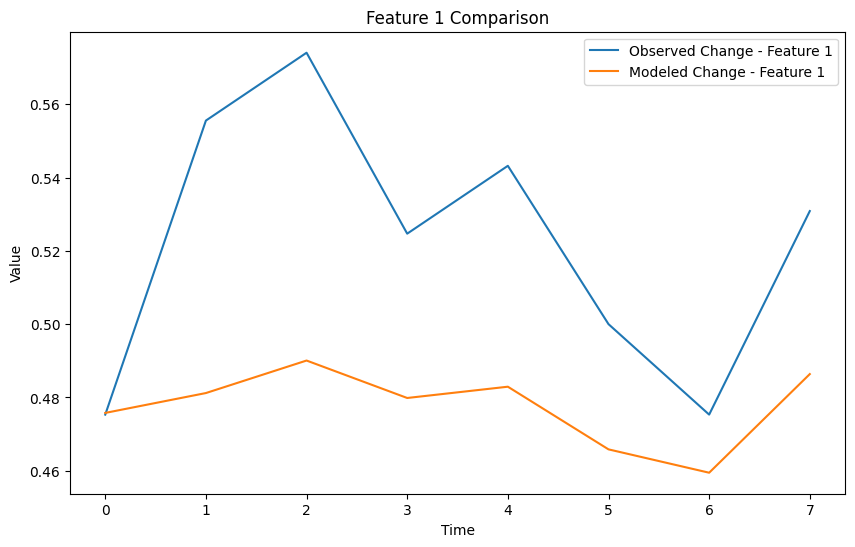

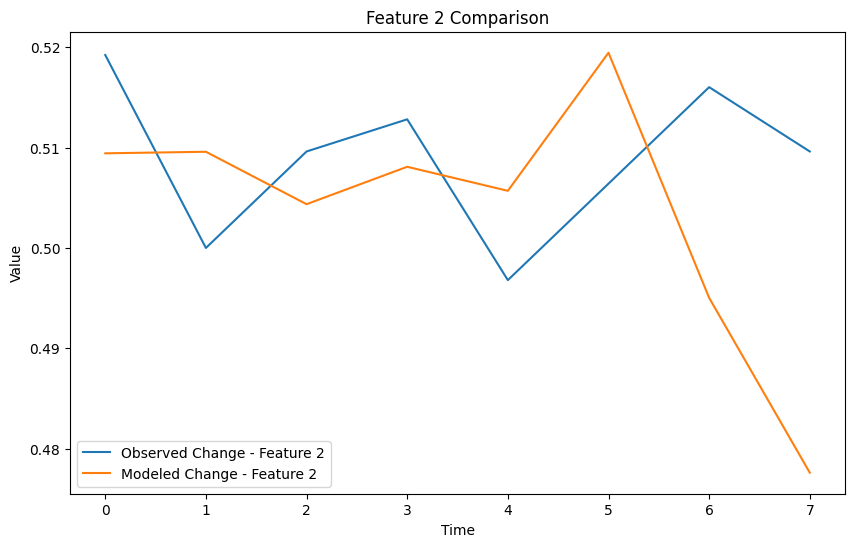

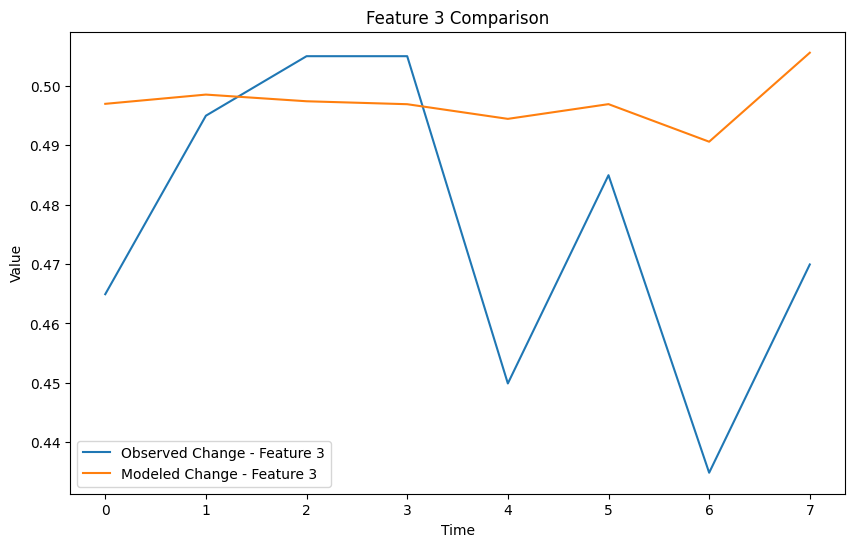

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Intialize Response Generator
generator = ResponseGenerator(cerberus_noforesight, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 4127
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

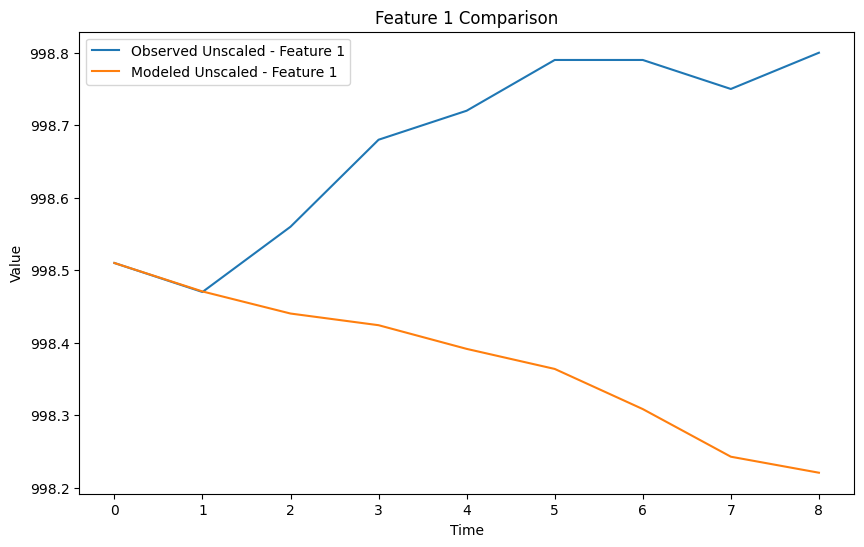

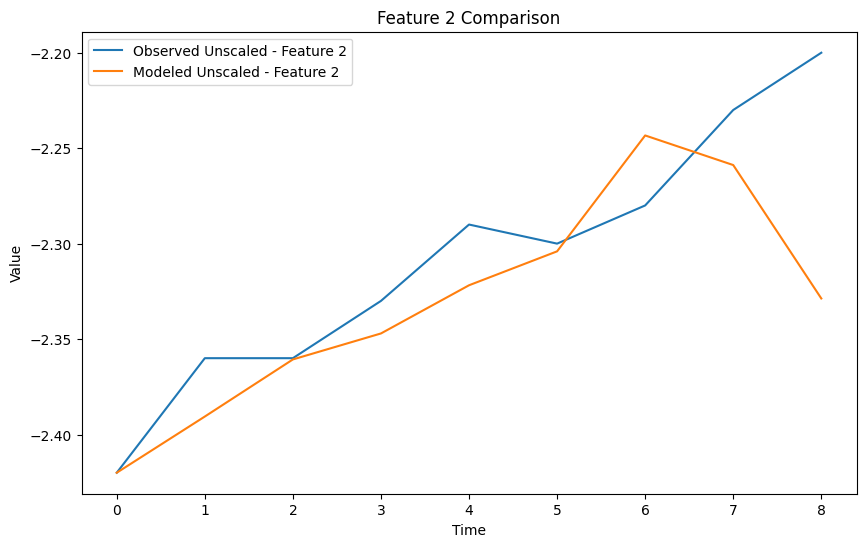

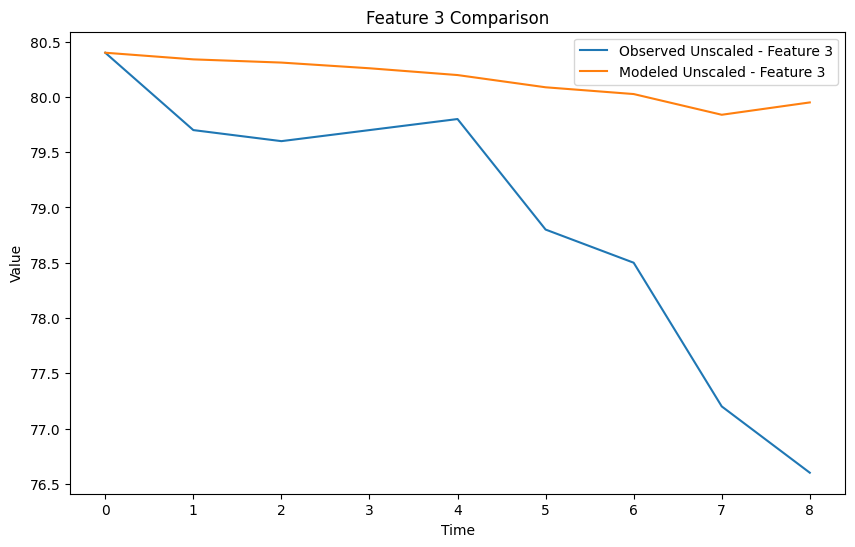

In [45]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)

In [ ]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(cerberus_foresight)